# Image Classification using ImageNette

> Image Classification using ImageNette


- skip_showdoc: true
- skip_exec: true

## Data Preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((375, 500)),
    transforms.ToTensor(),
])

# Download and load the Imagenette dataset
train_dataset = datasets.Imagenette(root='Data',
                                    split='train',
                                    # download=True,
                                    transform=transform,
                                    )


# Download and load the Imagenette dataset
test_dataset = datasets.Imagenette(root='Data',
                                  split='val',
                                  # download=True,
                                  transform=transform,
                                 )

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

dataloaders = {'train': train_loader, 'test': test_loader}

In [ ]:
train_dataset.__dict__.keys()

dict_keys(['root', 'transform', 'target_transform', 'transforms', '_split', '_size', '_url', '_md5', '_size_root', '_image_root', 'wnids', 'wnid_to_idx', 'classes', 'class_to_idx', '_samples'])

In [ ]:
train_dataset.classes

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [ ]:
len(train_dataset), len(test_dataset)

(9469, 3925)

In [ ]:
images, labels = train_dataset[10]
images.shape

torch.Size([3, 375, 500])

In [ ]:

# Define a function to display images
def show_image(dataset):
    # Access an image and its label from the dataset
    image, label = dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f' {train_dataset.classes[label][0]}')
    plt.show()
    
   
# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Convert image to numpy array and adjust pixel values
        img_np = images[i].numpy().transpose((1, 2, 0))
        
        # Display image
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f' {train_dataset.classes[labels[i]][0]}')
    plt.show()

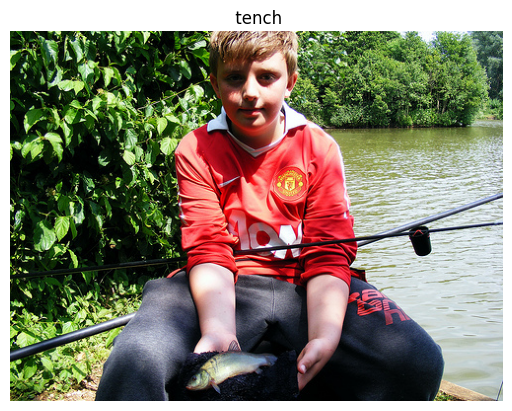

In [ ]:
show_image(train_dataset[2])

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)

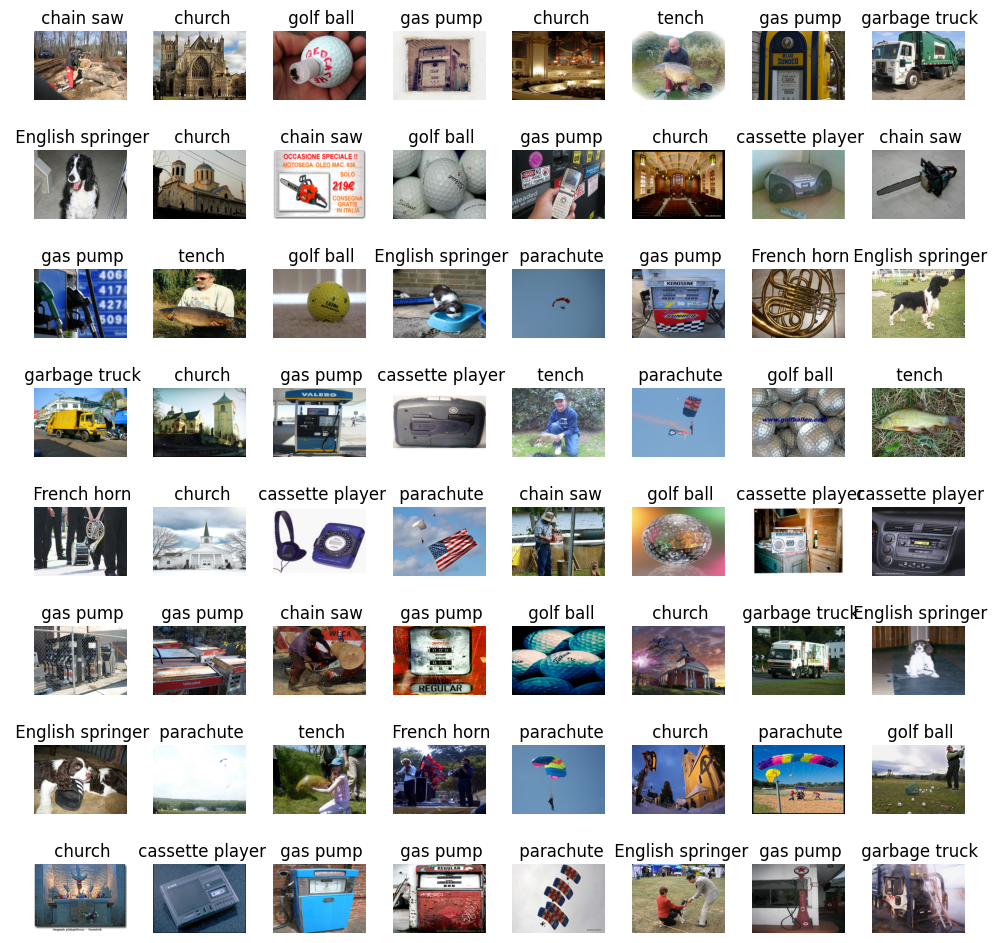

In [ ]:
show_images(images, labels)

## Model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    import time, copy, os
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import timm

In [ ]:
model = timm.create_model('resnet18',
                          pretrained=True,
                          num_classes=10)


In [ ]:
learning_rate = 0.001
num_epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
model = train_model(model = model,
                    criterion = criterion,
                    optimizer = optimizer,
                    scheduler = step_lr_scheduler,
                    num_epochs = 2)

Epoch 0/1
----------
